In [ ]:
## Using Conv1D network on time series for classification 

In [239]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline 
# %matplotlib qt


In [240]:
#Import datasets
think_df = pd.read_pickle("F:\EEG-data\\think-count\splits\\0.1s/raw_think.pkl")
count_df = pd.read_pickle("F:\EEG-data\\think-count\splits\\0.1s/raw_count.pkl")

print(think_df.shape)
print(count_df.shape)
print(think_df.iloc[0,0].shape)
print(count_df.iloc[0,0].shape)

(320, 32)
(320, 32)
(12,)
(12,)


In [241]:
# Shape each dataframe into 320,12,32
def reshape_df(df):
    new_df = np.zeros((320,12,32))
    for i in range(32):
        channel = df.iloc[:,i].values 
        channel_df = np.zeros((320,12))
        for j in range(len(channel)):
            channel_df[j,:] = channel[j]
        new_df[:,:,i] = keras.utils.normalize(channel_df)
    return new_df

In [242]:
r_think_df = reshape_df(think_df)
r_count_df = reshape_df(count_df)

In [243]:
X = np.vstack((r_think_df,r_count_df))
y = np.hstack((np.zeros(r_think_df.shape[0]),np.ones(r_count_df.shape[0])))
print(X.shape)
print(y.shape)

(640, 12, 32)
(640,)


In [244]:
#Split into train and test sets
def split_train_test(X,y):
    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for train_index, test_index in sss.split(X,y):
                x_train, x_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
    return x_train,x_test,y_train,y_test

In [245]:
x_train,x_test,y_train,y_test = split_train_test(X,y)

In [246]:
print(x_train.shape)
print(x_test.shape)

(512, 12, 32)
(128, 12, 32)


In [247]:
#DNN model

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12*32, input_shape = (12,32), activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 12, 384)           12672     
_________________________________________________________________
dense_108 (Dense)            (None, 12, 10)            3850      
_________________________________________________________________
dense_109 (Dense)            (None, 12, 1)             11        
Total params: 16,533
Trainable params: 16,533
Non-trainable params: 0
_________________________________________________________________


In [248]:
tf.random.set_seed(10)
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset = dataset.batch(40)
devset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
devset = devset.batch(40)

history = model.fit(dataset,epochs=500,verbose=0,validation_data=devset)
loss,accuracy = model.evaluate(x_test,y_test) 

print(accuracy)

4/4 [==============================] - 0s 4ms/step - loss: 0.2572 - accuracy: 0.9557
0.9557291865348816


In [81]:
# tf.random.set_seed(10)
loss,accuracy = model.evaluate(x_test,y_test) 

print(accuracy)

4/4 [==============================] - 0s 3ms/step - loss: 0.4149 - accuracy: 0.9525
0.9524739980697632


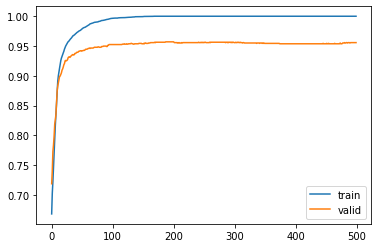

In [297]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'],label="train")
plt.plot(history.history['val_accuracy'],label="valid")
plt.legend()

In [298]:
# Testing batch size 
batchsizes = np.linspace(1,50,50)
batch_histories = []
for batch in batchsizes:
    dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
    devset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
    batch = int(batch)
    dataset = dataset.batch(batch)
    devset = devset.batch(batch)
    batch_history = model.fit(dataset,epochs=100,verbose=0,validation_data=devset)
    batch_histories.append(batch_history)
    print(batch)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


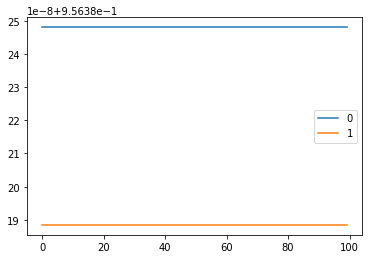

In [314]:
fig,ax = plt.subplots()
for i,history in enumerate(batch_histories[30:32]):
    ax.plot(history.history["val_accuracy"],label=str(i))
ax.legend()


In [308]:
max_val_acc = np.max(np.array([np.max(history.history['val_accuracy']) for history in batch_histories]))
max_val_acc_batch = batchsizes[np.argmax(np.array([np.max(history.history['val_accuracy']) for history in batch_histories]))]
print(max_val_acc)
print(max_val_acc_batch)

0.9648436307907104
1.0


In [291]:
## Conv1D Model 
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=5,strides=1, padding="causal",
                              activation="relu",input_shape=(12,32)), #input shape = (n_timesteps,n_features)
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",activation="relu"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,strides=1, padding="causal",activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="relu"), 
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
# optimizer = tf.keras.optimizers.Adam(lr=9e-4)
model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 12, 128)           20608     
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 12, 64)            41024     
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 12, 32)            10272     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 6, 32)             0         
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 6, 16)             2576      
_________________________________________________________________
flatten_34 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 10)              

In [292]:
tf.random.set_seed(10)
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset = dataset.batch(40)
devset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
devset = devset.batch(40)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# history2 = model2.fit(dataset,epochs=100,verbose=0,validation_data=devset,callbacks=[lr_schedule])
history2 = model2.fit(dataset,epochs=200,verbose=0,validation_data=devset)

loss2,accuracy2 = model2.evaluate(x_test,y_test) 

print(accuracy2)

#batch40,epochs10,0.9688,default learning rate 

4/4 [==============================] - 0s 6ms/step - loss: 0.3444 - accuracy: 0.9531
0.953125


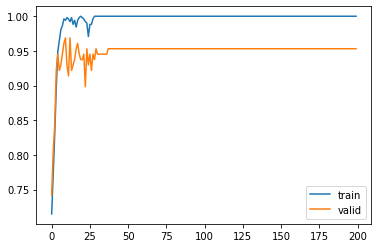

In [293]:
# plt.plot(history2.history['loss'])
# plt.plot(history2.history['val_loss']) 
plt.plot(history2.history['accuracy'],label="train")
plt.plot(history2.history['val_accuracy'],label="valid")
plt.legend()

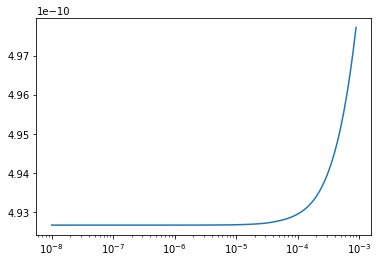

In [273]:
plt.semilogx(history2.history["lr"], history2.history["loss"])


In [ ]:
0.9375 conv64-conv64-dropout0.5-pool2-flatten-dense10-sigmoid
0.9453 conv32-conv32-pool2-flatten-dense10-sigmoid
0.9531 conv32-conv16-dropout0.5-pool2-flatten-dense10-sigmoid
0.9609 conv128-conv64-pool2-conv32-conv16-flatten-dense10-sigmoid
0.9688 conv128-conv64-conv32-pool2-conv16-flatten-dense10-sigmoid

In [188]:
## Conv1D + LSTM 
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=5,strides=1, padding="causal",
                              activation="relu",input_shape=(12,32)), #input shape = (n_timesteps,n_features)
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",activation="relu"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,strides=1, padding="causal",activation="relu"),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(10, activation="relu"), 
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model3.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
model3.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 12, 128)           20608     
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 12, 64)            41024     
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 12, 32)            10272     
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 6, 32)             0         
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 6, 16)             2576      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 6, 64)             12544     
_________________________________________________________________
dense_94 (Dense)             (None, 6, 10)           

In [237]:
tf.random.set_seed(10)
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset = dataset.batch(40)
# dataset = dataset.cache().shuffle(100).batch(40)
devset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
devset = devset.batch(40)

history3 = model3.fit(dataset,epochs=500,verbose=0,validation_data=devset) #default epochs = 10

loss3,accuracy3 = model3.evaluate(x_test,y_test) 

print(accuracy3)

4/4 [==============================] - 0s 7ms/step - loss: 0.4889 - accuracy: 0.9609
0.9609375


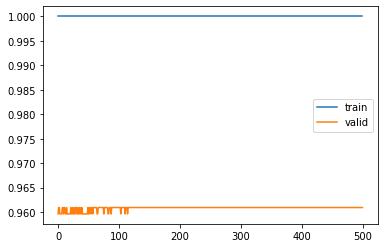

In [265]:
# plt.plot(history3.history['loss'])
# plt.plot(history3.history['val_loss'])
plt.plot(history3.history['accuracy'],label="train")
plt.plot(history3.history['val_accuracy'],label="valid")
plt.legend()

In [227]:
#Simple RNN
model4 = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(40, input_shape = (12,32),return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
# tf.keras.layers.Dense(10,activation="relu",input_shape=(12,32)),
  tf.keras.layers.Dense(1,activation="sigmoid"),
])
model4.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
model4.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 12, 40)            2920      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 41        
Total params: 6,201
Trainable params: 6,201
Non-trainable params: 0
_________________________________________________________________


In [228]:
tf.random.set_seed(10)
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset = dataset.batch(40)
devset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
devset = devset.batch(40)

history4 = model4.fit(dataset,epochs=500,verbose=0,validation_data=devset)

loss4,accuracy4 = model4.evaluate(x_test,y_test) 

print(accuracy4)

4/4 [==============================] - 0s 3ms/step - loss: 0.8086 - accuracy: 0.8828
0.8828125


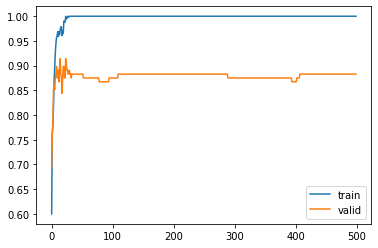

In [229]:
# plt.plot(history4.history['loss'])
# plt.plot(history4.history['val_loss'])
plt.plot(history4.history['accuracy'],label="train")
plt.plot(history4.history['val_accuracy'],label="valid")
plt.legend()

In [2]:
#LSTM only
model5 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True),input_shape = (12,32)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(1,activation="sigmoid"),
])
model5.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
model5.summary()

NameError: name 'tf' is not defined

In [211]:
tf.random.set_seed(10)
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
devset  = tf.data.Dataset.from_tensor_slices((x_test,y_test))
dataset = dataset.batch(40)
devset = devset.batch(40)

history5 = model5.fit(dataset,epochs=100,verbose=0,validation_data=devset)

loss5,accuracy5 = model5.evaluate(x_test,y_test) 

print(accuracy5)

4/4 [==============================] - 0s 6ms/step - loss: 0.7972 - accuracy: 0.9102
0.91015625


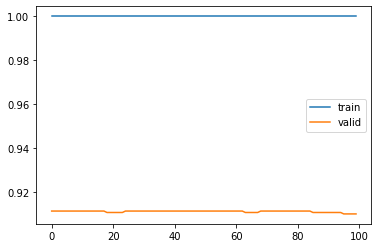

In [217]:
# plt.plot(history5.history['loss'])
# plt.plot(history5.history['val_loss'])

plt.plot(history5.history['accuracy'],label="train")
plt.plot(history5.history['val_accuracy'],label="valid")
plt.legend()
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']